# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1h2XYextVhBV0g-m34BFQzbXs2-TBEMB4/view?usp=sharing

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab4 Data Imputation.ipynb

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd
import ssl

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [8]:
#getting the min, max and average values in each column for subdf
print("The minimum values in the 'age', 'yredu', 'capgain', 'caploss' and 'workhr' columns are -")
min_vals=[subdf.min()][0]
df_min = pd.DataFrame(min_vals, columns=['minimum values'])
print(df_min)

print()

print("The maximum values in the 'age', 'yredu', 'capgain', 'caploss' and 'workhr' columns are -")
max_vals=[subdf.max()][0]
df_max = pd.DataFrame(max_vals, columns=['maximum values'])
print(df_max)

print()

print("The average values in the 'age', 'yredu', 'capgain', 'caploss' and 'workhr' columns are -")
avg_vals=[subdf.mean()][0]
df_avg = pd.DataFrame(avg_vals, columns=['average values'])
print(df_avg)

The minimum values in the 'age', 'yredu', 'capgain', 'caploss' and 'workhr' columns are -
         minimum values
age                  17
yredu                 1
capgain               0
caploss               0
workhr                1

The maximum values in the 'age', 'yredu', 'capgain', 'caploss' and 'workhr' columns are -
         maximum values
age                  90
yredu                16
capgain           99999
caploss            4356
workhr               99

The average values in the 'age', 'yredu', 'capgain', 'caploss' and 'workhr' columns are -
         average values
age           38.581647
yredu         10.080679
capgain     1077.648844
caploss       87.303830
workhr        40.437456


In [9]:
#Normalization
df["age"]=(subdf["age"]-subdf["age"].min())/(subdf["age"].max()-subdf["age"].min())
df["yredu"]=(subdf["yredu"]-subdf["yredu"].min())/(subdf["yredu"].max()-subdf["yredu"].min())
df["capgain"]=(subdf["capgain"]-subdf["capgain"].min())/(subdf["capgain"].max()-subdf["capgain"].min())
df["caploss"]=(subdf["caploss"]-subdf["caploss"].min())/(subdf["caploss"].max()-subdf["caploss"].min())
df["workhr"]=(subdf["workhr"]-subdf["workhr"].min())/(subdf["workhr"].max()-subdf["workhr"].min())

#to check normalization (i.e. values are between 0 and 1)
df[:5]

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,234721,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,338409,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [10]:
# hint: you can do something like this in pandas
#percentage of males and females in the dataset
percentage_male = sum(df["sex"] == " Male")/(sum(df["sex"] == " Female")+sum(df["sex"] == " Male"))*100
print("Percentage of males in dataset : ", round(percentage_male,3), "%")
print("Percentage of females in dataset : ", round(100-percentage_male, 3), "%")

Percentage of males in dataset :  66.921 %
Percentage of females in dataset :  33.079 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [11]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [12]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [13]:
#records containing missing features and the percentage that was removed
print("The number of records containing missing features are : ", len(df_with_missing))
print("The percentage of records that was removed was : ", round((len(df_with_missing)/len(df))*100,3),"%")

The number of records containing missing features are :  1843
The percentage of records that was removed was :  5.66 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [14]:
#set of possible values for work in df_not_missing
print("The possible values of work in df_not_missing are :", set(df_not_missing["work"]))

The possible values of work in df_not_missing are : {' Local-gov', ' Without-pay', ' Private', ' Self-emp-inc', ' Self-emp-not-inc', ' Federal-gov', ' State-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [15]:
data = pd.get_dummies(df_not_missing)

In [16]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [17]:
#number of columns
print("The number of columns (features) in the dataframe data are: ", data.shape[1])

The number of columns (features) in the dataframe data are:  57


There were originally 14 columns in our dataset but since we used the get_dummies function in pandas to get one-hot encoding; we basically split each categorical variable into levels, each of which it got its own column and would be 1 when observed or 0 when not. Eg. the "sex" column is split into "sex_male" and "sex_female", here they take on the values 0 and 1 respectively if sex=female, and 1 and 0 respectively if sex=male. Doing this one-hot encoding for all such varaibles increased the columns (features) from 14 to 57.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [18]:
datanp = data.values.astype(np.float32)
#print(datanp)

In [19]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

#print(cat_values)
#print(cat_index)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    one_hot = np.argmax(onehot)
    return cat_values[feature][one_hot]

#testing working of get_categorical_value function
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

State-gov
Private


In [20]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [21]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)
import math
#todo
rows = int(datanp.shape[0])
trainsplit=0.7
valsplit = 0.15
testsplit = 0.15
np.random.shuffle(datanp)
trainset = datanp[0:math.floor(rows*trainsplit)]
valset = datanp[math.floor(rows*trainsplit):math.floor(rows*trainsplit + rows*valsplit)]
testset = datanp[math.floor(rows*trainsplit+rows*valsplit):len(datanp)]

#Number of entries in training, validation and testing sets after random splitting into a 70, 15, 15 proportion
print("The number of data entries in the training set is : ", len(trainset))
print("The number of data entries in the validation set is : ", len(valset))
print("The number of data entries in the testing set is : ", len(testset))


The number of data entries in the training set is :  21502
The number of data entries in the validation set is :  4608
The number of data entries in the testing set is :  4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [23]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        #having fully-connected layers with reLU activation function
        self.encoder = nn.Sequential(
            nn.Linear(57,57), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(57,45),
            nn.ReLU(),
            nn.Linear(45,30)
        )
        #decoding the encoded sequence
        self.decoder = nn.Sequential(
            nn.Linear(30,45), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(45,57),
            nn.ReLU(),
            nn.Linear(57,57),
            #sigmoid function here to get output in range (0,1) due to its nature
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The sigmoid function as learnt earlier in the course enables us to get output values from the decoder between 0 and 1 through the make-up of the function. Earlier we had used the dummies function on our data to create categorical variables with one-hot encoding (0 or 1 output), and had also normalized some other features to get outputs between 0 and 1. As a result of doing this both the input to the autoencoder and the output from the sigmoid function while decoding have values between 0 and 1, making them easier to compare when matching.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [24]:
from torch.nn.modules.loss import TripletMarginLoss
import time
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

#adding in a batch_size hyperparameter to our training function as one of the adjustable parameters
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4, batch_size=128):

    #using code from lab 2 to setup lists of zeroes
    # Set up some lists to store the training/validation loss/accuracy
    train_accs = []
    train_losses = []
    val_accs = []
    val_losses = []
    iters = []

    """ Training loop. You should update this."""
    #populating in the train_loader and valid_loader inputs from our trainset and valset
    #using code from lab 3 to do so, where we also made training and validation loaders
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #to get training time using code from lab 2
    start_time = time.time()
    for epoch in range(num_epochs):

        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #also creating a loop for validation so that validation loss can be calculated and plotted later
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            val_loss = criterion(recon, data)

        #using code from lab 2 and lab 3 to store the training and validation errors and losses for each epoch
        iters.append(epoch)
        train_losses.append(float(train_loss)/batch_size)
        train_accs.append(get_accuracy(model, train_loader))
        val_losses.append(float(val_loss)/batch_size)
        val_accs.append(get_accuracy(model, valid_loader))
        #printing the training accuracy and losses for all epochs to understand the training and validation effectiveness
        print("epoch number : ", epoch+1, ", training_accuracy : ",train_accs[epoch],", training_loss : ",train_losses[epoch],
              ", validation_accuracy : ",val_accs[epoch],", validation_loss : ",val_losses[epoch])

    #recording the time elapsed
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

#using code from lab 2 to get curves for loss and error on training and validation
    import matplotlib.pyplot as plt
    plt.title("Train vs Validation Accuracy")
    n = num_epochs # number of epochs
    plt.plot(range(1,n+1), train_accs, label="Train")
    plt.plot(range(1,n+1), val_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_losses, label="Train")
    plt.plot(range(1,n+1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [25]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch number :  1 , training_accuracy :  0.3021269339286268 , training_loss :  0.0016074032755568624 , validation_accuracy :  0.30183015046296297 , validation_loss :  0.001594372559338808
epoch number :  2 , training_accuracy :  0.45907357455120457 , training_loss :  0.0005873340414837003 , validation_accuracy :  0.4580078125 , validation_loss :  0.0005830985028296709
epoch number :  3 , training_accuracy :  0.4598486962453105 , training_loss :  0.0005574787501245737 , validation_accuracy :  0.4585503472222222 , validation_loss :  0.0005466880393214524
epoch number :  4 , training_accuracy :  0.45918984280532044 , training_loss :  0.0005485236179083586 , validation_accuracy :  0.4577907986111111 , validation_loss :  0.000557267980184406
epoch number :  5 , training_accuracy :  0.45987194989613367 , training_loss :  0.0005499570979736745 , validation_accuracy :  0.45851417824074076 , validation_loss :  0.0005371131119318306
epoch number :  6 , training_accuracy :  0.4624453539205655 , t

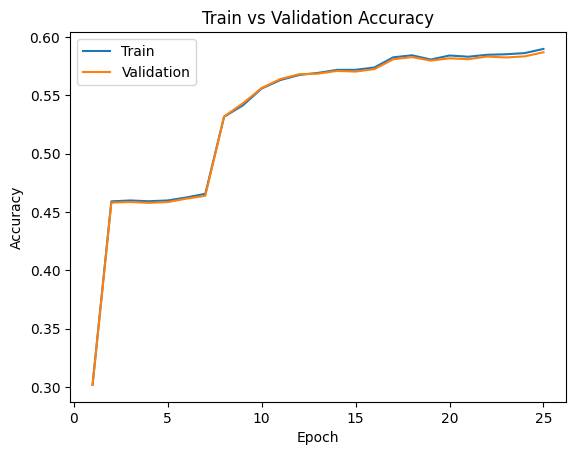

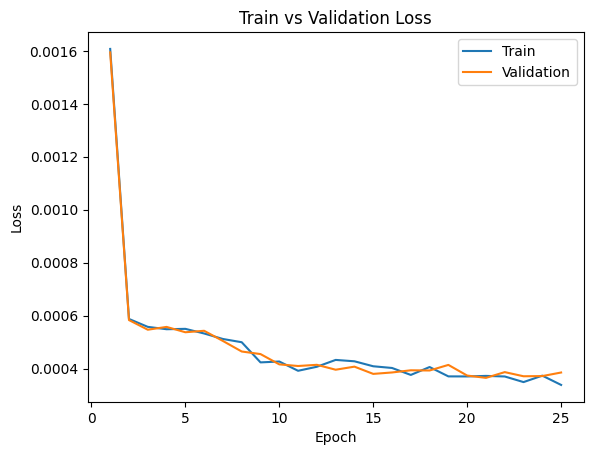

In [ ]:
#running the model with base hyperparameters, except for the fact that num_epochs are now 25.
#batch_size=128, learning_rate = 1e-4
model = AutoEncoder()
train(model, trainset, valset, num_epochs=25, batch_size=128, learning_rate=0.0001)

#training and validation curves included below after epochwise results

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

In [ ]:
#Based on training with the baseline model above it seems that the training accuracy plateaued for a bit around 3-7 epochs but then went up again
#and was increasing throughout till the end on 25 epochs. The validation and training losses also seem to reduce in correlation with each other,
#suggesting there is no under/overfitting as of now. So I will first try making the num_epochs 50 but keeping the other hyperparameters the same
#at batch_size = 128, learning_rate = 1e-4, to understand what changes to make next.

model = AutoEncoder()
train(model, trainset, valset, num_epochs=50, batch_size=128, learning_rate=0.0001)

#Results from this configuration of the model
#num_epochs = 50, batch_size = 128, learning_rate = 1e-4
#The most optimal training and validation losses and accuracies are included in the line below.
#epoch number :  48 , training_accuracy :  0.6079589495550801 , training_loss :  0.0003062727628275752 , validation_accuracy :  0.6036964699074074 ,
#validation_loss :  0.00027882796712219715

In [ ]:
#Based on training with the first model above it seems that the training accuracy plateaued for a bit around 25-35 epochs but then went up again
#and was almost increasing throughout till the end on 48 epochs. The validation and training losses also seem to reduce in correlation with each other,
#suggesting there is no under/overfitting as of now. So I will now try making the num_epochs 48 but will change the other hyperparameters a bit such that the
#batch_size = 128, but learning_rate = 0.00025 to increase the training and validation accuracies a bit quicker in hopes to understand when/if under/over
#fitting happens to tune the parameters appropriately for the next model.

model = AutoEncoder()
train(model, trainset, valset, num_epochs=48, batch_size=128, learning_rate=0.00025)

#Results from this configuration of the model
#num_epochs = 48, batch_size = 128, learning_rate = 0.00025
#The most optimal training and validation losses and accuracies are included in the line below.
#epoch number :  48 , training_accuracy :  0.6185083558118625 , training_loss :  0.00017583578301128 , validation_accuracy :  0.6159215856481481 ,
#validation_loss :  0.00019933722796849906

In [ ]:
#Based on training with the second model above it seems that the training accuracy did not plateau even for a bit and was increasing throughout till the
#end on 48 epochs. The validation and training losses also seem to reduce in correlation with each other, suggesting there is no under/overfitting as of
#now. So I will now try making the num_epochs a lot higher at 100 and will change the other hyperparameters a bit such that the batch_size = 64 because
#it seems that the accuracies starts to slow a bit in the last epochs, but decreasing the batch_size should help the model learn better, keeping learning_rate = 0.00025
#to increase the training and validation accuracies a bit quicker in hopes to understand when/if under/over fitting happens to tune the parameters appropriately
#for the next model.

model = AutoEncoder()
train(model, trainset, valset, num_epochs=100, batch_size=64, learning_rate=0.00025)

#Results from this configuration of the model
#num_epochs = 100, batch_size = 64, learning_rate = 0.00025
#The most optimal training and validation losses and accuracies are included in the line below.
#epoch number :  100 , training_accuracy :  0.6474048925681332 , training_loss :  0.00016188288282137364 , validation_accuracy :  0.6399739583333334 ,
#validation_loss :  0.00012349356256891042

In [ ]:
#Based on training with the second model above it seems that the training accuracy did not plateau even for a bit and was increasing throughout till the
#end on 100 epochs. The validation and training losses also seem to reduce in correlation with each other, suggesting there is no under/overfitting as of
#now. At this point num_epochs are not making a great difference so I keep it at 100 and will change the other hyperparameters a bit such that the
#batch_size = 32 because it seems that it bumped up the accuracies a lot in the third model as compared to the first two, and decreasing the batch_size should help
#the model learn better as seen, I will also change the learning_rate to learning_rate = 0.0005 to increase the training and validation accuracies a bit quicker
#in hopes to maximize accuracies while minimizing the losses.

model = AutoEncoder()
train(model, trainset, valset, num_epochs=100, batch_size=32, learning_rate=0.0005)

#Results from this configuration of the model
#num_epochs = 100, batch_size = 32, learning_rate = 0.0005
#The most optimal training and validation losses and accuracies are included in the line below.
#epoch number :  100 , training_accuracy :  0.674231854401141 , training_loss :  0.00012375452206470072 , validation_accuracy :  0.6672815393518519 ,
#validation_loss :  0.000354739953763783

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
num_workers = 1
batch_size = 32 #from the best model above
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)

#since the last model was the best one, just using it directly to obtain accuracy on the testing set
print("Testing accuracy is : ", round((get_accuracy(model, test_loader))*100,3), "%")

Testing accuracy is :  66.641 %


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [26]:
#using the marriage column example to get accuracy
mode=df_not_missing['marriage'].value_counts().idxmax()
count=0
common=[]
num_of_entries = len(df_not_missing)
for i in range(0,num_of_entries):
  common.append(mode)
df_common = pd.DataFrame(common, columns=['marriage'])
num = df_not_missing['marriage'].isin(df_common['marriage']).value_counts()
print("Percentage accuracy in predicting 'marriage' feature of baseline model is : ")
print(round((num/num_of_entries)*100,3))

#the test accuracy of the baseline model is thus : 46.679%

Percentage accuracy in predicting 'marriage' feature of baseline model is : 
False    53.321
True     46.679
Name: marriage, dtype: float64


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy of my model from part(a) is 66.641% as compared to the baseline models accuracy of 46.679%. The accuracy of my autoencoder model
with hyperparameters learning_rate = 0.0005, num_epochs = 100, and batch_size = 32 is significantly higher than the baseline. However, even 66.641% is
not a very good accuracy in general, this might be as a cause of trying to predict features that are not correlated between samples and rather just random data points that can differ greatly from sample to sample without much reasoning.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
#we can use the get_features function defined earlier in part 1 to obtain the features for the random person
print(get_features(testset[0]))

{'work': 'Private', 'marriage': 'Divorced', 'occupation': 'Prof-specialty', 'edu': 'Bachelors', 'relationship': 'Not-in-family', 'sex': 'Male'}


As said earlier in part (c), it is really difficult to say anything for sure about the person's education level based on the other features as there is no direct correlation between them. However, a reasonable estimate (narrowing down to a few options) about the education level can be made using the occupation. A professional speciality occupation likely requires the person to have a good level of education and a bachelors degree is proof of that. A general guess can't say for sure whether they should have a bachelors or a higher level of education though, so it is not reasonable.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [29]:
#to get a prediction for the education level we first need to zero that feature for the given test subject, we can do this using the zero_out_feature function;
#we can then use the get_feature function defined earlier to get a prediction for the education level
print("My model's predicition for this person's education is: ", get_feature(model(torch.from_numpy(zero_out_feature(testset[0:1], "edu")[0])).detach(), "edu"))

My model's predicition for this person's education is:  Bachelors


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
#since the baseline model's predicition is just the most common value for any feature in the dataset, in the case of education we can find this as follows
print("The baseline model's prediction for this person's education is : ", df_not_missing['edu'].value_counts().idxmax())

The baseline model's prediction for this person's education is :   HS-grad
